<span style="color:#44f;font-weight:bold;">Codes for CNS2025: Lecture 4</span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
resting_potential = -70   # Resting potential (mV)
reset_potential = -80   # Reset potential (mV)
sigma = 0.03 # Noise amplitude (mA s^{-1/2})
input_resistance = 50     # Input resistance (ohm)
background_current = 0.1   # Background current (mA)
firing_threshold = -50  # Firing threshold (mV)
tau_membrane = 0.02 # Membrane time constant (s)
membrane_potential_init = resting_potential    # Initial membrane potential (mV)
delta_t = 0.001 # Time between frames (s)
refractory_period = .005 # Refractory period (s)

In [3]:
duration = 10  # simulate for 10s
membrane_potential = membrane_potential_init # initial state
num_frames = int(duration/delta_t) # number of time frames

# traces
membrane_potential_trace = []  # Membrane potential
input_current_trace = []  # Input stimulus current
times = []  # Time points
spike_train = []  # Frame-based spike train

rng = np.random.default_rng(1234)
time = 0
last_fire = -refractory_period
for frame_index in range(num_frames):
    input_current = sigma*rng.normal()/np.sqrt(delta_t)+background_current
    membrane_potential += delta_t*(resting_potential-membrane_potential+input_current*input_resistance)/tau_membrane
    time += delta_t
    membrane_potential_trace.append(membrane_potential)
    input_current_trace.append(input_current)
    times.append(time)
    if membrane_potential>firing_threshold:
        membrane_potential = reset_potential
        spike_train.append(1)
        last_fire = time
    else: spike_train.append(0)
    if time-last_fire<refractory_period: membrane_potential = reset_potential
times,membrane_potential_trace = np.array(times),np.array(membrane_potential_trace)
input_current_trace,spike_train = np.array(input_current_trace),np.array(spike_train)

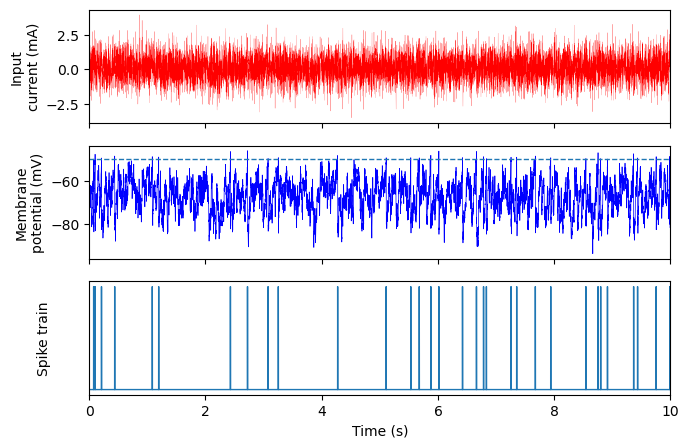

In [4]:
f,aa = plt.subplots(3,1,figsize=(7.5,5),sharex=True)
aa[0].plot(times,input_current_trace,lw=.125,color='r')
aa[0].set_xlim(0,delta_t*num_frames)
aa[0].set_ylabel('Input\ncurrent (mA)')
aa[1].plot(times,membrane_potential_trace,lw=.5,color='b')
aa[1].plot([0,num_frames*delta_t],[firing_threshold,firing_threshold],'--',lw=1)
aa[1].set_ylabel('Membrane\npotential (mV)')
aa[2].plot(times,spike_train,lw=1)
aa[2].set_yticks([])
aa[2].set_ylabel('Spike train\n\n')
aa[2].set_xlabel('Time (s)')
plt.show()

# Spike-triggered average

In [5]:
with np.load('lec04-data.npz',allow_pickle=True) as f:
    input_currents = f['input_currents']
    spike_train = f['spike_train']
    delta_t = f['delta_t'][()]
num_frames = len(input_currents) # Number of frames
times = np.arange(num_frames)*delta_t # Times of the frames
duration = num_frames*delta_t

In [6]:
win_range = np.array([-0.2,0.02]) # Relative range of window
[win_rindex_start,win_rindex_end] = (win_range/delta_t).astype(int) # Relative range of array index

In [7]:
# Loop implementation
spike_trigger_sum = np.zeros(win_rindex_end-win_rindex_start) # Spike-triggered sum
spike_count = 0
for index in range(-win_rindex_start,num_frames-win_rindex_end):
    if spike_train[index]==0: continue
    spike_trigger_sum += input_currents[index+win_rindex_start:index+win_rindex_end]
    spike_count += 1
print(f'Average over {spike_count} spikes')
spike_trigger_average_1 = spike_trigger_sum/spike_count-input_currents.mean() # Remove constant background current

# Array comprehension implementation
spike_trigger_average_2 = np.mean([
    input_currents[index+win_rindex_start:index+win_rindex_end]
    for index in np.where(spike_train)[0]
    if index+win_rindex_start>=0 and index+win_rindex_end<len(input_currents)
],axis=0)-input_currents.mean()

print('Same results from both implementations:',np.all(spike_trigger_average_1==spike_trigger_average_2))

Average over 3393 spikes
Same results from both implementations: True


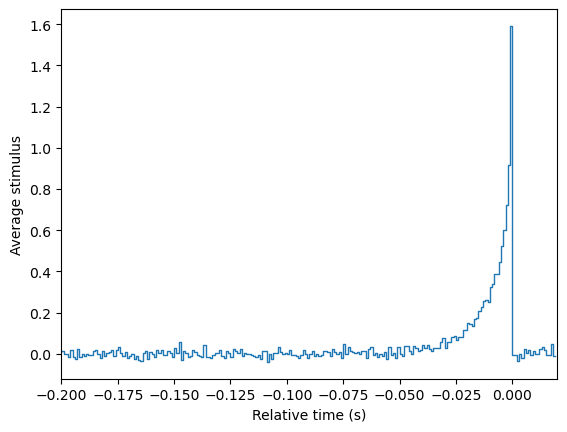

In [8]:
plt.step(np.arange(*win_range,delta_t),spike_trigger_average_1,lw=1)
plt.xlim(win_range)
plt.xlabel('Relative time (s)')
plt.ylabel('Average stimulus')
plt.show()

In [9]:
from matplotlib.patches import Rectangle

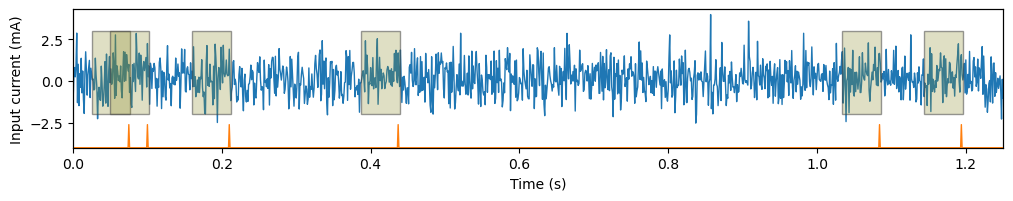

In [10]:
plot_range = [0,1.25] # Range to plot
averaging_window = [-0.05,0.002] # Averging window
f,a = plt.subplots(1,1,figsize=(12,1.8),sharex=True)
times = np.array(times)
input_currents = np.array(input_currents)
spike_train = np.array(spike_train)
indices = (times>=plot_range[0])*(times<=plot_range[1])
a.plot(times[indices],input_currents[indices],lw=1)
a.set_xlim(plot_range)
a.set_ylabel('Input current (mA)')
a.set_ylim(-4,None)
b = a.twinx()
b.plot(times[indices],spike_train[indices],c='C1',lw=1)
b.set_ylim(0,6)
b.set_yticks([])
a.set_xlabel('Time (s)')

for time in times[indices][np.where(spike_train[indices])]:
    a.add_patch(Rectangle(
        (time+averaging_window[0],-2),averaging_window[1]-averaging_window[0],5,
        facecolor='#8824',edgecolor='#4448',zorder=10
    ))
plt.show()

In [11]:
spikes_in_range = times[indices][np.where(spike_train[indices])] # Spikes in range

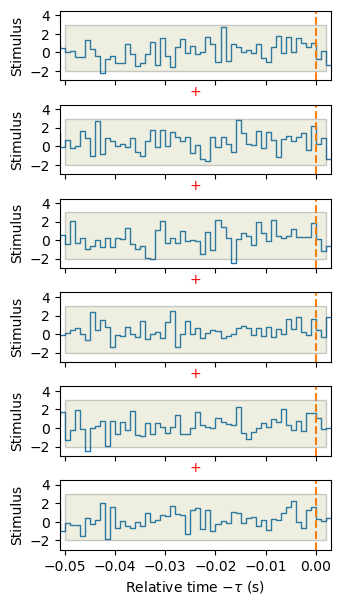

In [12]:
f,aa = plt.subplots(len(spikes_in_range),1,figsize=(3.5,7),sharex=True)
f.subplots_adjust(hspace=0.35)
spike_trigger_sum = np.zeros(int((averaging_window[1]-averaging_window[0])/delta_t)+1)
for time,a in zip(spikes_in_range,aa):
    [index_start,index_end] = np.round(((averaging_window+time)/delta_t)+[-1,2]).astype(int)
    a.step(np.arange(0,index_end-index_start)*delta_t-0.05-delta_t,input_currents[index_start:index_end],lw=1)
    spike_trigger_sum += input_currents[index_start+1:index_end-1]
    a.set_xlim(averaging_window[0]-delta_t,averaging_window[1]+delta_t)
    a.add_patch(Rectangle((averaging_window[0],-2),averaging_window[1]-averaging_window[0],5,facecolor='#8822',edgecolor='#4444',zorder=10))
    a.plot([0,0],[-3,4.5],'--',color='C1')
    a.set_ylim(-3,4.5)
    a.set_yticks([-2,0,2,4])
    a.set_ylabel('Stimulus')
    if time==spikes_in_range[-1]:
        a.set_xlabel(r'Relative time $-\tau$ (s)')
    else:
        a.set_xlabel('+',labelpad=0,color='red')
plt.show()

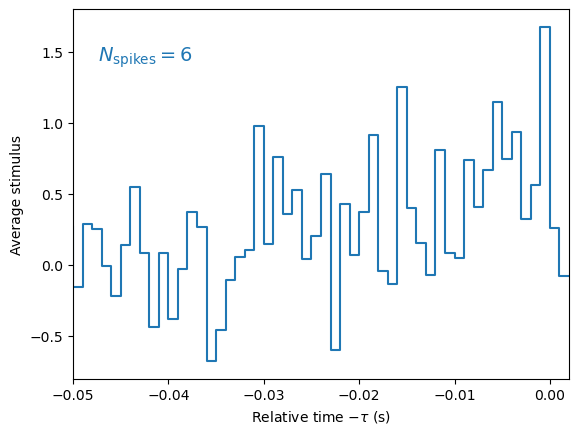

In [13]:
plt.step(np.arange(len(spike_trigger_sum))*delta_t+averaging_window[0],spike_trigger_sum/len(spikes_in_range))
plt.xlim(averaging_window)
plt.ylim(-0.8,1.8)
plt.xlabel(r'Relative time $-\tau$ (s)')
plt.ylabel('Average stimulus')
plt.text(
    0.05,0.86,fr'$N_\mathrm{{spikes}}={len(spikes_in_range)}$',
    transform=plt.gca().transAxes,color='C0',fontsize=14)
plt.show()

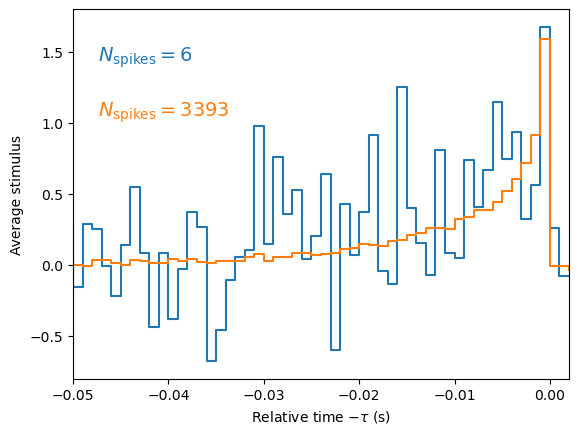

In [14]:
plt.step(np.arange(len(spike_trigger_sum))*delta_t+averaging_window[0],spike_trigger_sum/len(spikes_in_range))
plt.step(np.arange(*win_range,delta_t),spike_trigger_average_1)
plt.xlim(*averaging_window)
plt.ylim(-0.8,1.8)
plt.xlabel(r'Relative time $-\tau$ (s)')
plt.ylabel('Average stimulus')
plt.text(
    0.05,0.86,fr'$N_\mathrm{{spikes}}={len(spikes_in_range)}$',
    transform=plt.gca().transAxes,color='C0',fontsize=14)
plt.text(
    0.05,0.71,fr'$N_\mathrm{{spikes}}={spike_count}$',
    transform=plt.gca().transAxes,color='C1',fontsize=14)
plt.show()

# Cross/auto correlation (covariance)

In [15]:
def shifted_product(a,b,d):
    '''Calculate the mean of a(t)b(t+d) over t
    
    Parameters
    ==========
    a,b :   Two 1d numpy arrays of the same size
      d :   Relative shift of b from a'''
    if d>0: return (a[:-d]*b[d:]).mean()
    if d<0: return (a[-d:]*b[:d]).mean()
    return (a*b).mean()

In [16]:
displace_range = np.arange(-100,100) # Range of displaced index
q_rs_1 = np.array([shifted_product(spike_train,input_currents,d) for d in displace_range])
# Alternative code using ternary operator
q_rs_2 = np.array([(
    spike_train[:-d]*input_currents[d:] if d>0 else
    spike_train[-d:]*input_currents[:d] if d<0 else
    spike_train*input_currents
).mean() for d in displace_range])
np.all(q_rs_1==q_rs_2)

np.True_

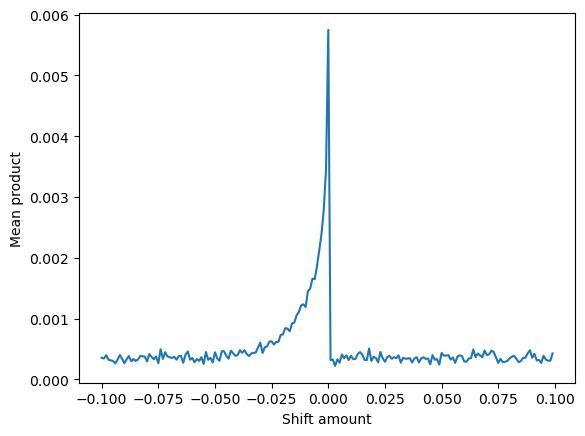

In [17]:
plt.plot(displace_range*delta_t,q_rs_1)
plt.xlabel('Shift amount')
plt.ylabel('Mean product')
plt.show()

## Use `np.roll` in place of shift 

In [18]:
def roll_corr(a,b,d_range):
    '''Calculate the cross correlation between a,b for the range d_range

    Parameters
    ==========
           a,b :  Two 1d numpy arrays of the same size
    d_range :  Range of relative shifts of b from a'''
    return np.array([(np.roll(a,d)*b).mean()-a.mean()*b.mean() for d in d_range])

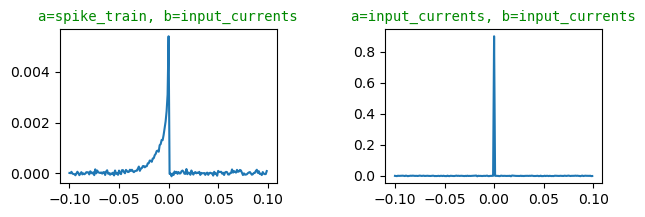

In [19]:
f,aa = plt.subplots(1,2,figsize=(7,2))
f.subplots_adjust(wspace=0.5)
fd = {'family':'monospace','size':'10','color':'#080'}
aa[0].plot(displace_range*delta_t,roll_corr(spike_train,input_currents,displace_range))
aa[0].set_title('a=spike_train, b=input_currents',fontdict=fd)
aa[1].plot(displace_range*delta_t,roll_corr(input_currents,input_currents,displace_range))
aa[1].set_title('a=input_currents, b=input_currents',fontdict=fd)
plt.show()

In [20]:
from scipy.stats import poisson,norm

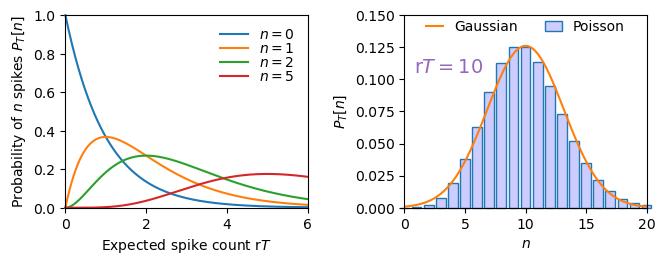

In [21]:
f,(a,b) = plt.subplots(1,2,figsize=(7.5,2.5))
f.subplots_adjust(wspace=0.4)
mu_values = np.arange(0,6,0.01)
for n in [0,1,2,5]:
    a.plot(mu_values,poisson.pmf(n,mu_values),clip_on=False,label=f'$n={n}$')
a.set_xlim(0,6)
a.set_ylim(0,1)
a.set_xlabel(r'Expected spike count $\mathrm{r}T$')
a.set_ylabel(r'Probability of $n$ spikes $P_T[n]$')
a.legend(labelspacing=0,frameon=False)
n_values = np.arange(21)
b.bar(n_values,poisson.pmf(n_values,10),clip_on=False,label='Poisson',edgecolor='C0',facecolor='#ccf')
n_continuous_values = np.linspace(0,20,101)
b.plot(n_continuous_values,norm.pdf(n_continuous_values,loc=10,scale=np.sqrt(10)),color='C1',label='Gaussian')
b.set_xlim(0,20)
b.set_ylim(0,0.15)
b.set_xlabel(r'$n$')
b.set_ylabel(r'$P_T[n]$')
b.legend(
    labelspacing=0,frameon=False,loc='upper center',
    ncol=2,handlelength=1.2,bbox_to_anchor=(0.5,1.04))
b.text(0.04,0.7,r'$\mathrm{r}T=10$',transform=b.transAxes,color='C4',fontsize=14)
plt.show()

# Linear-nonlinear model

In [22]:
# Generate made-up stimulus input
rng = np.random.default_rng(12345)
noise = rng.normal(size=10000)
window = np.exp(-np.arange(0,200)/40)
window /= window.sum()
input_currents = np.convolve(noise,window)[:-len(window)+1] # Create some correlation in input current

In [23]:
print('processing',num_frames:=len(input_currents),'frames')
delta_t = 0.001
times = np.arange(num_frames)*delta_t    # Time frames
duration = num_frames*delta_t
time_range = np.array([0,duration]) # Time range

processing 10000 frames


In [24]:
from matplotlib.transforms import Bbox

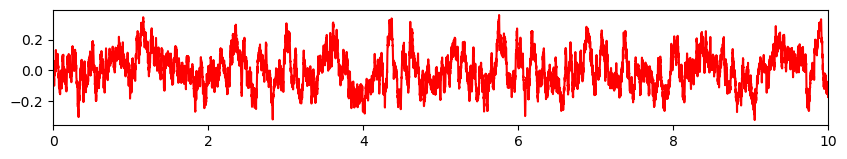

In [25]:
plt.figure(figsize=(10,1.5))
plt.plot(times,input_currents,color='#f00')
plt.xlim(time_range)
plt.show()

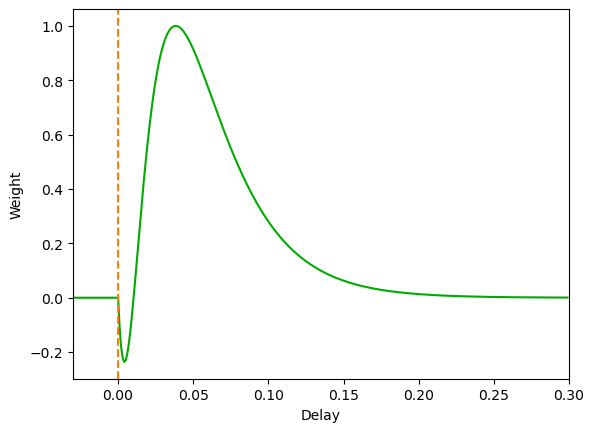

In [26]:
win_range = np.array([-0.03,0.3]) # Kernel time range
win_times = np.arange(*win_range,delta_t) # Kernel time frames
# Make up a nontrivil kernel
win_kernel = np.exp(-win_times/.032)-1.8*np.exp(-win_times/.016)+0.8*np.exp(-win_times/.008)
win_kernel *= (win_times>0)  # Make negative delay part zero (causal)
win_kernel /= max(win_kernel) # Normalize max to 1

plt.plot(win_times,win_kernel,color='#0a0')
plt.xlim(win_range)
plt.axvline(0,ls='--',color='C1')
plt.ylabel('Weight')
plt.xlabel('Delay')
plt.show()

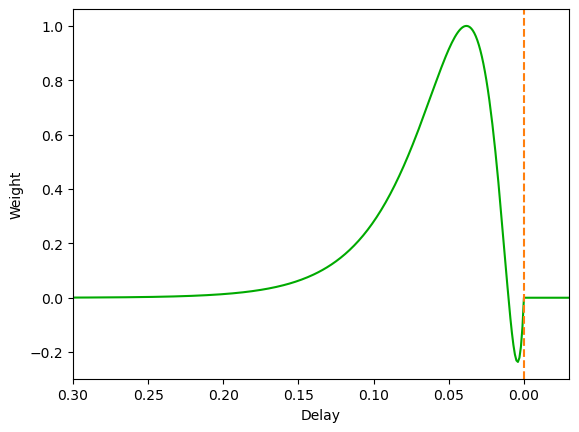

In [27]:
# How it is usually shown...
plt.plot(win_times,win_kernel,color='#0a0')
plt.xlim(win_range[::-1])
plt.axvline(0,ls='--',color='C1')
plt.ylabel('Weight')
plt.xlabel('Delay')
plt.show()

In [28]:
# Linear filter and nonlinear rectification...
front_drop = (win_times<0).sum() # Number of frames to drop in front
rect = lambda x:np.log(1+np.exp(x)) # Some rectifying function
mu_values = rect(np.convolve(input_currents,win_kernel)[front_drop:front_drop-len(win_kernel)+1])

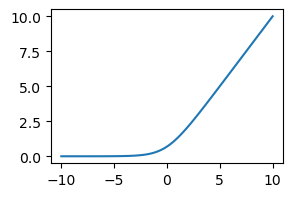

In [29]:
# Show rectification function
x = np.linspace(-10,10,101)
plt.figure(figsize=(3,2))
plt.plot(x,rect(x))
plt.show()

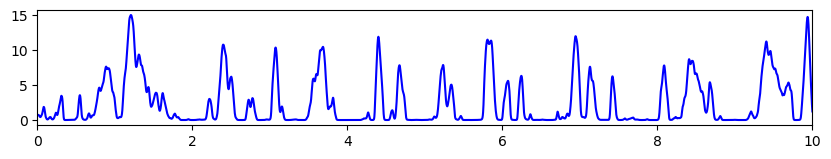

In [30]:
# Show resulting firing rate
plt.figure(figsize=(10,1.5))
plt.plot(times,mu_values,color='#00f')
plt.xlim(time_range)
plt.show()

In [31]:
mu_values.shape

(10000,)

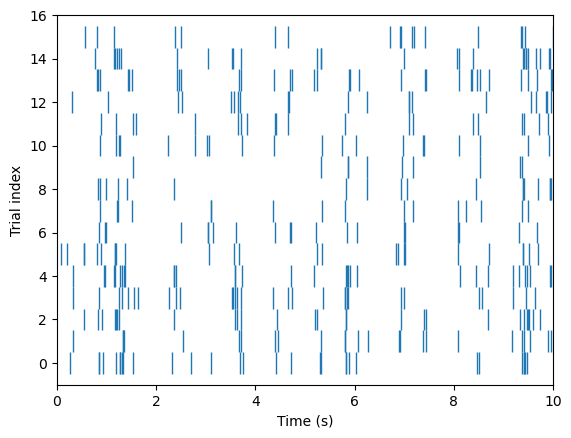

In [32]:
num_trials = 16
for seed in range(num_trials):
    rng = np.random.default_rng(seed)
    spike_train = rng.uniform(size=mu_values.shape)<mu_values*delta_t
    plt.vlines(np.where(spike_train)[0]*delta_t,seed-.5,seed+.5,lw=1)
plt.xlim(time_range)
plt.ylim(-1,num_trials)
plt.xlabel('Time (s)')
plt.ylabel('Trial index')
plt.show()

<hr>
<address style="color:#44f;font-style:italic;font-weight:bold;"><a href="https://cc.tir.tw/wk/2025cns">CNS2025</a></address>